# Upwelling velocities notebook

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cmocean
import os
from datetime import datetime
from matplotlib import gridspec
from salishsea_tools import grid_tools, tidetools, viz_tools, places, utilities

%matplotlib inline
plt.rcParams['font.size'] = 12

/home/bmoorema/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


## Local functions

In [260]:
def make_pressure_diagram():
    """Quick plotting code for pressure diagram
    """

    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([0.1, 0.8])
    ax.yaxis.set_ticklabels(['$z=-h$', '$z=0$'])

    # Add lines
    x = np.arange(0, 1.01, 0.01)
    ax.plot([0, 1], [0.8, 0.8], 'k--')
    ax.plot([0, 1], [0.1, 0.1], 'k--')
    ax.plot(x, np.sin(2*np.pi*x-1.5)/6 + 0.8, 'k-')
    ax.plot(x, np.sin(2*np.pi*x-1.5)/15 + 0.1, 'k-')

    # Add labels
    ax.arrow(0.5, 0.8, 0, 0.14, head_width=0.01, fc='k')
    ax.arrow(0.5, 0.105, 0, 0.04, head_width=0.01, fc='k')
    ax.arrow(0.24, 0.1, 0, 0.68, head_width=0.01, fc='k')
    ax.arrow(0.48, 0.175, 0, 0.765, head_width=0.01, fc='k')
    ax.text(0.505, 0.86, '$\eta$')
    ax.text(0.505, 0.12, '$\\xi$')
    ax.text(0.245, 0.5, '$\sum_k^0e3t(0)$')
    ax.text(0.485, 0.5, '$\sum_k^0e3t(t)$')

    plt.show()
    
    return

In [4]:
def calc_sigma_surface():
    """Calculate 1022 surface depth
    """
    
    index = abs(rho - 1022).argmin(axis=1)
    p, _, m, n = VVL['gdept_t'].shape
    depth_1022 = np.zeros((p, m, n))
    for t in range(p):
        for j in range(m):
            for i in range(n):
                depth_1022[t, j, i] = VVL['gdept_t'][t, index[t, j, i], j, i]
                
    return depth_1022

## Velocity decomposition
We would like to show that the ageostrophic velocities in the lower layer of the model are onshore and stronger near protruding coastlines.

First we calculate the total pressure field

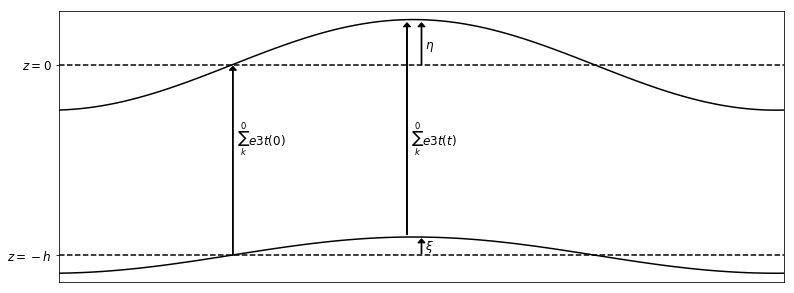

In [261]:
make_pressure_diagram()

$$\xi = \eta - \left(\sum_k^0e3t(t) - \sum_k^0e3t(0)\right)$$

$$p = g\int_{-h}^\eta\rho dz = g\int_{-h+\xi}^\eta\rho dz + g\rho_{deep}\xi$$

Next, we calculate the geostrophic velocities from the pressure gradient force.

$$f \times \mathbf{u}_g = -\frac{1}{\rho}\nabla p$$

$$\mathbf{u}_a = \mathbf{u} - \mathbf{u}_g$$

In [273]:
def calc_geostrophic_velocities(idepth):
    """Calculate pressure gradients and geostrophic velocities at idepth
    """

    # Calculate z surface displacement xi
    stretching = VVL['e3t_t'][:, :idepth, ...].sum(axis=1) - e3t_0[:, :idepth, ...].sum(axis=1)
    xi = eta - stretching

    # Define rho at z surface
    rho_bot = rho[:, idepth, ...]
    rho_bot[xi < 0] = rho[:, idepth - 1, ...][xi < 0]

    # Calculate pressure
    pressure = g * ((rho[:, :idepth, ...] * VVL['e3t_t'][:, :idepth, ...]).sum(axis=1) + rho_bot * xi)
    pressure = pressure - (eta + gdept_0[:, idepth, ...])*5e2

    # Calculate the pressure gradient
    dpdy, dpdx = np.gradient(pressure, axis=(1, 2))

    # Extract and unstagger the model velocity fields
    u = U.vozocrtx[tslice, idepth, yslice, xslice].values
    v = V.vomecrty[tslice, idepth, yslice, xslice].values
    u[:, 1:, 1:], v[:, 1:, 1:] = viz_tools.unstagger(u, v)

    # Calculate the geostrophic velocities
    u_g = -1 / (f * rho[:, idepth, ...]) * dpdy / mask.e2t[:, yslice, xslice].values
    v_g = 1 / (f * rho[:, idepth, ...]) * dpdx / mask.e1t[:, yslice, xslice].values

    # Calculate ageostrophic velocities
    u_a = u - u_g
    v_a = v - v_g

    # Filter tides
    GEO = {
        'u': u,                     #tidetools.filter_timeseries(u),
        'v': v,                     #tidetools.filter_timeseries(v),
        'u_g': u_g,                 #tidetools.filter_timeseries(u_g),
        'v_g': v_g,                 #tidetools.filter_timeseries(v_g),
        'u_a': u_a,                 #tidetools.filter_timeseries(u_a),
        'v_a': v_a,                 #tidetools.filter_timeseries(v_a),
        'eta': eta,                 #tidetools.filter_timeseries(eta),
        'pressure': pressure,       #tidetools.filter_timeseries(pressure),
    }

    return GEO

## Full configuration - no tides

Load run files

In [5]:
# Load run files
results_path = '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15lake'
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
TRC = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150424_20150429_ptrc_T.nc'))
T = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150424_20150429_grid_T.nc'))
U = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150424_20150429_grid_U.nc'))
V = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150424_20150429_grid_V.nc'))
GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
GEM = GEM.sel(time=slice('2015 Apr 24', '2015 Apr 29'))

Define slices and parameters

In [6]:
# Gravitational acceleration
g = 9.81
f = 1e-4

# Define slices
trange = [34, 124]
xrange = [115, 220]
yrange = [500, 675]
tslice = slice(*trange)
xslice = slice(*xrange)
yslice = slice(*yrange)

# Define dims
x = mask.x[xslice].values
y = mask.y[yslice].values

# Define parameters
e3t_0 = mask.e3t_0[..., yslice, xslice].values
gdept_0 = mask.gdept_0[..., yslice, xslice].values
tmask = mask.tmask[0, :, yslice, xslice].values
eta = T.sossheig[tslice, yslice, xslice].values

# Upwelling tracer field
tracer = TRC.mytracer3[tslice, 0, yslice, xslice]
GEM = GEM.isel(time=tslice)

# Depth index
idepth = 23

Calculate time-dependent vertical grid, $\rho$ and geostrophic velocities

In [7]:
# Obtain the time dependent grid parameters
VVL = grid_tools.calculate_time_dependent_grid(e3t_0[0, ...], tmask, eta, {'e3t_t': e3t_0, 'gdept_t': gdept_0})

# Calculate rho
rho = gsw.rho(T.vosaline[tslice, :, yslice, xslice], T.votemper[tslice, :, yslice, xslice], VVL['gdept_t'])

# Calculate geostrophic velocities
GEO = calc_geostrophic_velocities(idepth)

Plot fields

In [193]:
def plotit(t):
    """Plot the pressure and velocity fields.
    """
    
    # Plot parameters
    trange_plot = [0, 90]
    tslice_plot = slice(*trange_plot)
    j, i = places.PLACES['Sisters Islet']['GEM2.5 grid ji']
    j_NEMO, i_NEMO = places.PLACES['Sisters Islet']['NEMO grid ji']
    index = GEM.v_wind[tslice_plot, j, i].values > 0

    # Make plot grid
    axs = []
    fig = plt.figure(figsize=(15, 9))
    gs = gridspec.GridSpec(2, 4, height_ratios=[1, 5])
    axs.append(fig.add_subplot(gs[0, :]))
    axs.extend([fig.add_subplot(gs[1, col]) for col in range(4)])
    cax = fig.add_axes([0.91, 0.15, 0.008, 0.52])

    # Plot wind record
    axs[0].fill_between(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, where=index, color='firebrick', interpolate=True)
    axs[0].fill_between(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, where=~index, color='darkslategray', interpolate=True)
    axs[0].plot(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, 'k-')
    axs[0].plot([GEM.time.values[t], GEM.time.values[t]], [-12, 12], 'k-')
    axs[0].set_xlim([GEM.time.values[trange_plot[0]], GEM.time.values[trange_plot[1]-1]])
    axs[0].set_ylim([-12, 12])
    axs[0].set_title('Alongstrait windspeed at Sisters Islet')
    axs[0].set_ylabel('m/s')
        
    # Plot pressure fields
    c = axs[1].contourf(
        x, y, GEO['pressure'][t, ...]*1e-4,
        #levels=np.arange(39.092, 39.105, 0.001),
        levels=np.arange(39.092, 39.118, 0.001),
        cmap=cmocean.cm.dense, extend='both',
    )
    fig.colorbar(c, cax=cax, label='dbar')

    # Plot velocity fields
    for col, key_u, key_v in zip(range(1, 4), ['u', 'u_g', 'u_a'], ['v', 'v_g', 'v_a']):
        index = (abs(GEO[key_u][t, ::5, ::5]) > 0.5) | (abs(GEO[key_v][t, ::5, ::5]) > 0.5)
        q = axs[1+col].quiver(
            x[::5], y[::5],
            np.ma.masked_where(index, GEO[key_u][t, ::5, ::5]),
            np.ma.masked_where(index, GEO[key_v][t, ::5, ::5]),
            scale=1, width=0.005,
        )
        # Formatting
        axs[1+col].yaxis.set_ticklabels('')
        axs[1+col].set_title(f'$\mathbf{{{key_u}}}_{{{int(mask.gdept_1d[0, idepth].values)}m}}$')
        axs[1+col].set_xlabel('Model grid x')

    # Formatting
    axs[1].set_ylabel('Model grid y')
    axs[1].set_title(f'$\mathbf{{p}}_{{{int(mask.gdept_1d[0, idepth].values)}m}}$')
    axs[1].set_xlabel('Model grid x')

    plt.quiverkey(q, 0.2, 0.05, 0.1, '0.1 m/s')

    for ax in axs[1:]:
        ax.contourf(x, y, tmask[0, ...], levels=[-0.01, 0.01], colors='Burlywood')
        ax.contour(x, y, tmask[0, ...], levels=[-0.01, 0.01], colors='k')
        ax.plot(i_NEMO, j_NEMO, 'ro', markeredgecolor='k', linewidth=2, markersize=10)
        viz_tools.set_aspect(ax)
    
    return fig

### Analysis

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in greater


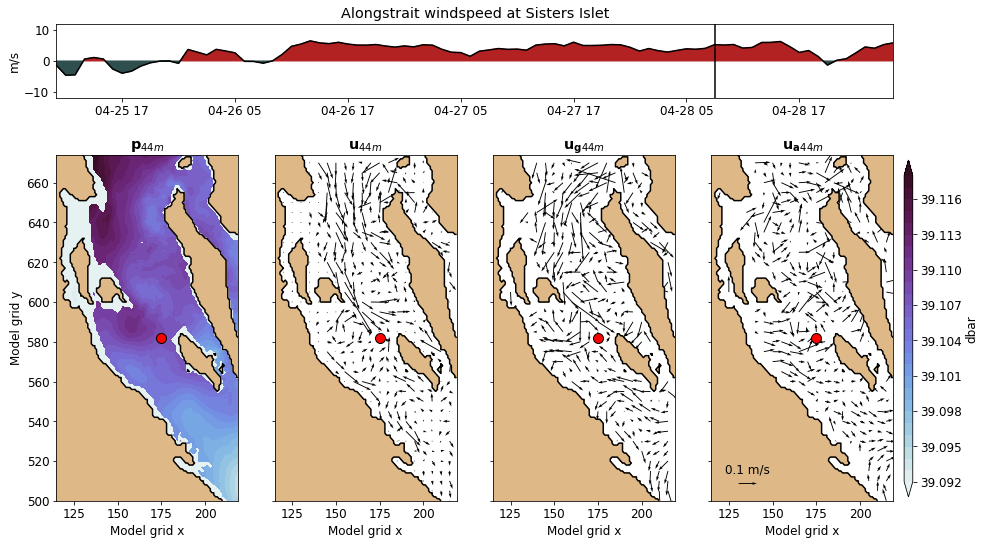

In [195]:
fig = plotit(70)

The lower layer ageostrophic currents in the full configuration are consistently offshore, likely due to the alongstrait pressure gradient that results from wind setup. Since this alongstrait setup is not accounted for in our conceptual model, the ageostrophic velocities that we calculate are not an accurate reflection of the cross-shore transport.

To investigate further, we do a similar analysis in an idealized configuration.

## Idealized configuration

Load run files

In [263]:
rundir = '/data/bmoorema/results/SalishSeaPond/SalishSeaPond_basic_summer_S24H_2layer'
prefix = 'SalishSeaIdeal_1h_20170701_20170705'
T = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_T.nc'))
U = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_U.nc'))
V = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_V.nc'))
mask = xr.open_dataset(os.path.join(rundir, 'mesh_mask.nc'))

Define slices and parameters

In [274]:
# Gravitational acceleration
g = 9.81
f = 1e-4

# Define slices
trange = [40, 41]
xrange = [0, 133]
yrange = [0, 512]
tslice = slice(*trange)
xslice = slice(*xrange)
yslice = slice(*yrange)

# Define dims
x = mask.x[xslice].values
y = mask.y[yslice].values

# Define parameters
e3t_0 = mask.e3t_0[..., yslice, xslice].values
gdept_0 = mask.gdept_0[..., yslice, xslice].values
tmask = mask.tmask[0, :, yslice, xslice].values
eta = T.sossheig[tslice, yslice, xslice].values

# Depth index
idepth = 24

Calculate time-dependent vertical grid, $\rho$ and geostrophic velocities

In [275]:
# Obtain the time dependent grid parameters
VVL = grid_tools.calculate_time_dependent_grid(e3t_0[0, ...], tmask, eta, {'e3t_t': e3t_0, 'gdept_t': gdept_0})

# Calculate rho
rho = gsw.rho(T.vosaline[tslice, :, yslice, xslice], T.votemper[tslice, :, yslice, xslice], VVL['gdept_t'])

# Calculate geostrophic velocities
GEO = calc_geostrophic_velocities(idepth)

In [276]:
def plotideal():
    """Plot idealized model results
    """
    
    fig, axs = plt.subplots(1, 4, figsize=(17, 18))
    cax = fig.add_axes([0.29, 0.15, 0.01, 0.7])

    for ax, tag in zip(axs, ['p', '', '_g', '_a']):
        if tag is 'e':
            levels = np.arange(-0.07, 0.08, 0.01)
            c = ax.contourf(GEO['eta'][0], levels=levels, cmap=cmocean.cm.dense, extend='both', zorder=0)
        elif tag is 'p':
            #levels = np.arange(35.128, 35.14, 0.001)
            levels = np.arange(33.2, 33.22, 0.001)
            c = ax.contourf(GEO['pressure'][0]*1e-4, levels=levels, cmap=cmocean.cm.deep, extend='both', zorder=0)
        else:
            mindex = (abs(GEO[f'u{tag}'][0]) > 0.1) | (abs(GEO[f'v{tag}'][0]) > 0.1)
            u = np.ma.masked_where(mindex, GEO[f'u{tag}'][0])
            v = np.ma.masked_where(mindex, GEO[f'v{tag}'][0])
            q = ax.quiver(T.x[::5], T.y[::5], u[::5, ::5], v[::5, ::5], scale=0.5, zorder=2)
            ax.yaxis.set_ticklabels('')
        ax.contourf(tmask[idepth, ...], levels=[-0.01, 0.01], colors='Burlywood', zorder=1)
        ax.contour(tmask[idepth, ...], levels=[-0.01, 0.01], colors='k', zorder=1)
        ax.set_xlim([20, 125])
        ax.set_ylim([0, 470])
        viz_tools.set_aspect(ax)

    axs[3].quiverkey(q, 0.15, 0.97, 0.05, '0.05 m/s')

    fig.colorbar(c, cax=cax)
    
    return

### Analysis - full pressure field

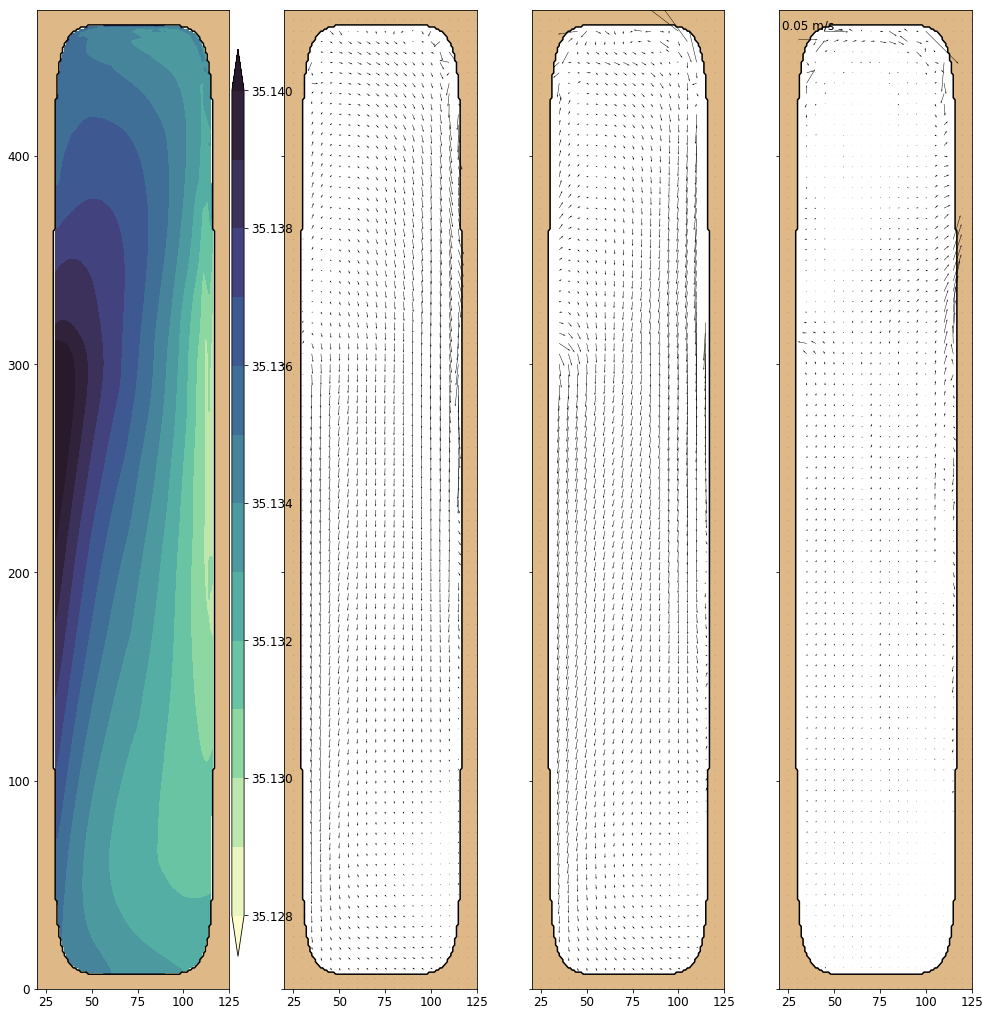

In [272]:
plotideal()

The ageostrophic currents in the lower layer are again offshore, likely due to the alongshore pressure gradient. What happens if we try and subtract the barotrophic pressure field from the full pressure field?

### Analysis - partial pressure field

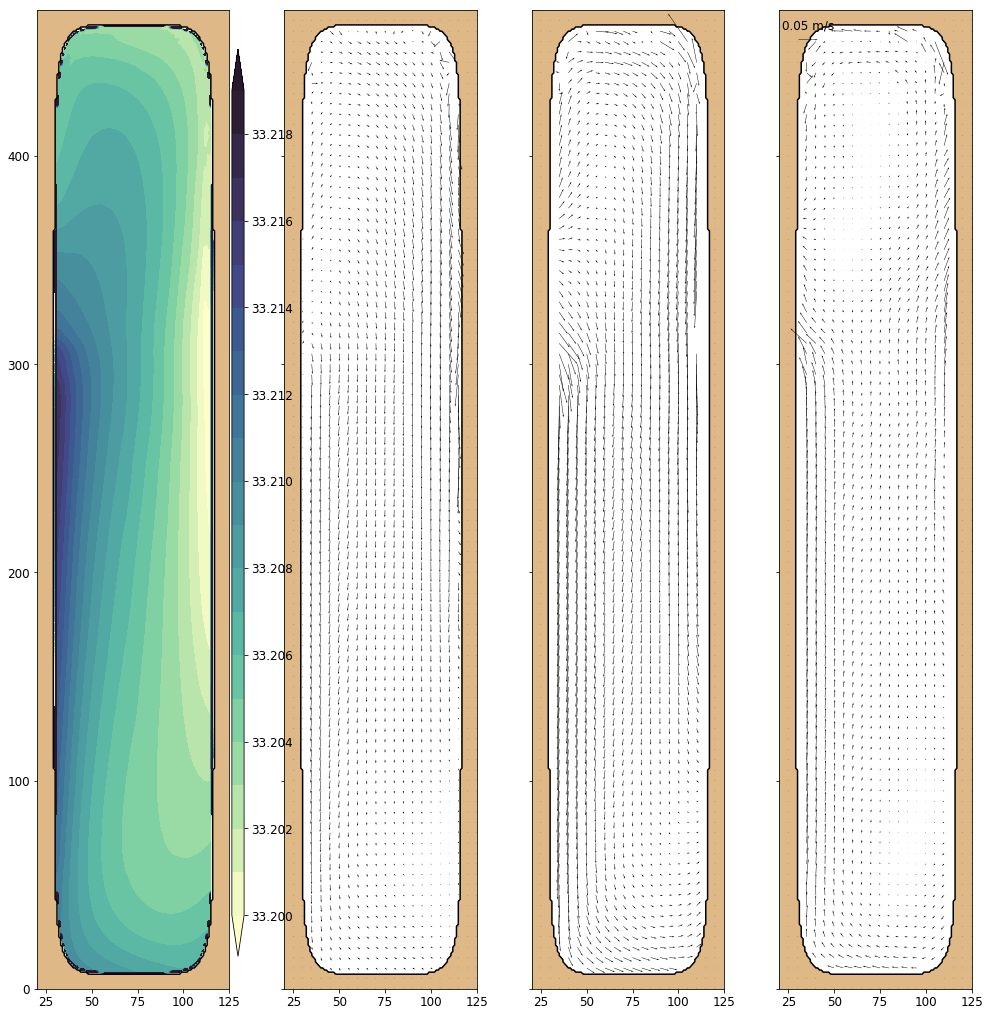

In [277]:
plotideal()